In [2]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/age_gender.zip"
!unzip -qo age_gender.zip 
!rm age_gender.zip

--2020-12-08 11:49:08--  https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/age_gender.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.64.4
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.64.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66303838 (63M) [application/x-zip-compressed]
Saving to: ‘age_gender.zip’

age_gender.zip      100%[===================>]  63.23M   100MB/s    in 0.6s    

2020-12-08 11:49:09 (100 MB/s) - ‘age_gender.zip’ saved [66303838/66303838]



In [28]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,InputLayer, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint

In [4]:
Dataset = pd.read_csv('age_gender.csv')
Dataset.head(5)

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [5]:
Dataset.describe()

,age,ethnicity,gender
count,23705.000000,23705.000000,23705.000000
mean,33.300907,1.269226,0.477283
std,19.885708,1.345638,0.499494
min,1.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000
50%,29.000000,1.000000,0.000000
75%,45.000000,2.000000,1.000000
max,116.000000,4.000000,1.000000


In [6]:
# Actually images are in string format, let's transform it in more useful type of data.

Dataset['pixels'] = Dataset['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

<AxesSubplot:>

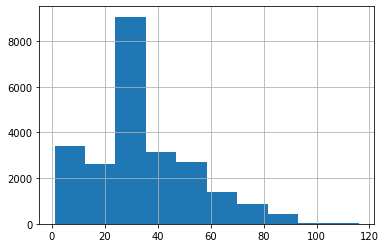

In [7]:
Dataset['age'].hist()

In [8]:
Dataset["age_cat"] = pd.cut(Dataset["age"],
                               bins=[0., 20., 40.0, 60., 80., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [9]:
Dataset["age_cat"].value_counts()

2    12122
1     4877
3     4311
4     1855
5      540
Name: age_cat, dtype: int64

In [10]:
Dataset['age_cat'].value_counts()/len(Dataset)

2    0.511369
1    0.205737
3    0.181860
4    0.078254
5    0.022780
Name: age_cat, dtype: float64

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(Dataset, Dataset["age_cat"]):
    strat_train_set = Dataset.loc[train_index]
    strat_test_set = Dataset.loc[test_index]

In [12]:
strat_test_set['age_cat'].value_counts()/len(strat_test_set)

2    0.511285
1    0.205864
3    0.181818
4    0.078254
5    0.022780
Name: age_cat, dtype: float64

In [13]:
def age_cat_proportions(data):
    return data["age_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(Dataset, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": age_cat_proportions(Dataset),
    "Stratified": age_cat_proportions(strat_test_set),
    "Random": age_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [14]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.205737,0.205864,0.201223,-2.193972,0.061513
2,0.511369,0.511285,0.517401,1.179673,-0.016499
3,0.181860,0.181818,0.178865,-1.646950,-0.023196
4,0.078254,0.078254,0.079730,1.886792,0.000000
5,0.022780,0.022780,0.022780,0.000000,0.000000


In [15]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("age_cat", axis=1, inplace=True)

In [16]:
strat_train_set

,age,ethnicity,gender,img_name,pixels
13327,35,1,1,20170117154137390.jpg.chip.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1216,10,4,1,20170104005649671.jpg.chip.jpg,"[[16.0, 13.0, 12.0, 10.0, 10.0, 14.0, 21.0, 29..."
7056,26,3,1,20170117153041485.jpg.chip.jpg,"[[37.0, 23.0, 14.0, 16.0, 18.0, 15.0, 16.0, 28..."
18424,50,0,0,20170104181517653.jpg.chip.jpg,"[[95.0, 93.0, 93.0, 106.0, 160.0, 180.0, 184.0..."
5273,24,2,1,20170116173419546.jpg.chip.jpg,"[[19.0, 22.0, 33.0, 50.0, 74.0, 102.0, 123.0, ..."
...,...,...,...,...,...
14209,36,0,0,20170105163417082.jpg.chip.jpg,"[[52.0, 46.0, 32.0, 35.0, 46.0, 94.0, 124.0, 1..."
3291,20,3,1,20170104222031311.jpg.chip.jpg,"[[128.0, 16.0, 30.0, 29.0, 15.0, 12.0, 12.0, 1..."
6976,26,3,1,20170117154857092.jpg.chip.jpg,"[[1.0, 1.0, 1.0, 2.0, 2.0, 6.0, 11.0, 30.0, 64..."
21892,7,0,0,20170110215534588.jpg.chip.jpg,"[[100.0, 114.0, 130.0, 125.0, 141.0, 129.0, 13..."


In [17]:
full_dataset = strat_train_set.append(strat_test_set)

In [18]:
full_dataset.head()

,age,ethnicity,gender,img_name,pixels
13327,35,1,1,20170117154137390.jpg.chip.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1216,10,4,1,20170104005649671.jpg.chip.jpg,"[[16.0, 13.0, 12.0, 10.0, 10.0, 14.0, 21.0, 29..."
7056,26,3,1,20170117153041485.jpg.chip.jpg,"[[37.0, 23.0, 14.0, 16.0, 18.0, 15.0, 16.0, 28..."
18424,50,0,0,20170104181517653.jpg.chip.jpg,"[[95.0, 93.0, 93.0, 106.0, 160.0, 180.0, 184.0..."
5273,24,2,1,20170116173419546.jpg.chip.jpg,"[[19.0, 22.0, 33.0, 50.0, 74.0, 102.0, 123.0, ..."


In [19]:
strat_test_set

,age,ethnicity,gender,img_name,pixels
20402,6,3,1,20161220223138171.jpg.chip.jpg,"[[34.0, 39.0, 43.0, 36.0, 48.0, 66.0, 89.0, 11..."
17678,48,3,0,20170119181346742.jpg.chip.jpg,"[[92.0, 85.0, 92.0, 106.0, 135.0, 148.0, 150.0..."
7736,26,0,0,20170117195743604.jpg.chip.jpg,"[[36.0, 42.0, 55.0, 49.0, 77.0, 94.0, 88.0, 88..."
10200,29,1,0,20170113145429766.jpg.chip.jpg,"[[254.0, 254.0, 255.0, 255.0, 255.0, 252.0, 24..."
5019,24,0,0,20170114030346768.jpg.chip.jpg,"[[56.0, 20.0, 17.0, 21.0, 18.0, 18.0, 18.0, 24..."
...,...,...,...,...,...
19765,56,0,1,20170109221138733.jpg.chip.jpg,"[[18.0, 19.0, 35.0, 16.0, 22.0, 45.0, 72.0, 10..."
3063,2,2,1,20161219141208216.jpg.chip.jpg,"[[243.0, 164.0, 66.0, 23.0, 49.0, 80.0, 71.0, ..."
15364,4,2,0,20161219200024691.jpg.chip.jpg,"[[23.0, 25.0, 39.0, 54.0, 70.0, 81.0, 84.0, 89..."
7990,26,0,1,20170117175317465.jpg.chip.jpg,"[[172.0, 172.0, 171.0, 173.0, 170.0, 170.0, 17..."


In [20]:
full_dataset['pixels'] = full_dataset['pixels'].apply(lambda x: x/255)

## calculating distributions
age_dist = full_dataset['age'].value_counts()
#print(age_dist)
ethnicity_dist = full_dataset['ethnicity'].value_counts()
#print(ethnicity_dist)
gender_dist = full_dataset['gender'].value_counts().rename(index={0:'Male',1:'Female'})
#print(gender_dist)

In [21]:
X = np.array(full_dataset['pixels'].tolist())

## Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48,1)

In [22]:

# split the data into train ad test
np.random.seed(42)
y_age = np.array(full_dataset['age'])
y_gender = np.array(full_dataset['gender'])
print('X',X.shape)
print('y_age',y_age.shape)
print('y_gender',y_gender.shape)

X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(X,y_age, y_gender, test_size=0.2, random_state=42)


X (23705, 48, 48, 1)
y_age (23705,)
y_gender (23705,)


In [23]:
def plot(X,y):
        plt.title(y)
        plt.imshow(X.reshape(48,48))
        plt.show()

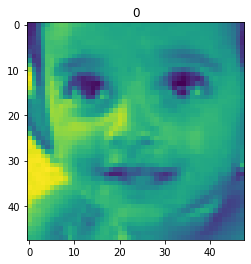

In [24]:
plot(full_dataset['pixels'][50],full_dataset['gender'][10])

In [25]:
import tensorflow.keras.layers as L

tf.keras.backend.clear_session()

AgeModel = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1)
])

AgeModel.compile(optimizer='adam',
              loss='mean_squared_error')



In [26]:
AgeModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [29]:
checkpointer = ModelCheckpoint('ageModel.h5', monitor='val_loss', mode='min', verbose=2, save_best_only=True)

In [31]:
history = AgeModel.fit(X_train, y_age_train, epochs=50, validation_split=0.2, batch_size=64,callbacks=[checkpointer])

Epoch 1/50
238/238 [==============================] - ETA: 0s - loss: 310.1414
Epoch 00001: val_loss improved from inf to 975.63641, saving model to ageModel.h5
238/238 [==============================] - 4s 19ms/step - loss: 310.1414 - val_loss: 975.6364
Epoch 2/50
236/238 [============================>.] - ETA: 0s - loss: 196.8810
Epoch 00002: val_loss improved from 975.63641 to 394.15063, saving model to ageModel.h5
238/238 [==============================] - 4s 17ms/step - loss: 196.7776 - val_loss: 394.1506
Epoch 3/50
238/238 [==============================] - ETA: 0s - loss: 171.1606
Epoch 00003: val_loss improved from 394.15063 to 197.25926, saving model to ageModel.h5
238/238 [==============================] - 4s 17ms/step - loss: 171.1606 - val_loss: 197.2593
Epoch 4/50
236/238 [============================>.] - ETA: 0s - loss: 156.8952
Epoch 00004: val_loss improved from 197.25926 to 154.32248, saving model to ageModel.h5
238/238 [==============================] - 4s 17ms/step 

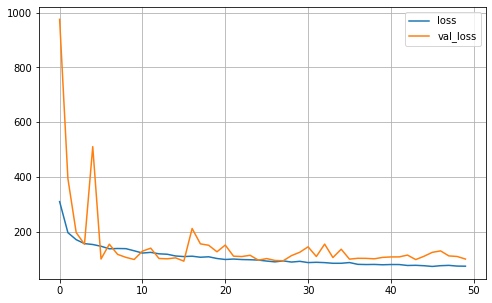

In [32]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [33]:
AgeModel.evaluate(X_test,y_age_test)

149/149 [==============================] - 1s 7ms/step - loss: 98.4495


98.44949340820312

In [34]:
y_age_test[:10]

array([90, 37, 35, 24, 40, 24, 21, 40, 54, 57])

In [35]:
y_age_pred = AgeModel.predict(X_test[:10])
np.round(y_age_pred)

array([[94.],
       [24.],
       [37.],
       [28.],
       [24.],
       [31.],
       [30.],
       [25.],
       [60.],
       [48.]], dtype=float32)

In [39]:
##Gender Model
tf.keras.backend.clear_session()
GenderModel = tf.keras.Sequential([
    L.InputLayer(input_shape=(48,48,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='sigmoid')
])

GenderModel.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [40]:
GenderModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                4

In [41]:
Gender_history = GenderModel.fit(
    X_train, y_gender_train, epochs=18, validation_split=0.2, batch_size=64)

Epoch 1/18
238/238 [==============================] - 4s 17ms/step - loss: 0.4367 - accuracy: 0.7912 - val_loss: 0.6143 - val_accuracy: 0.8205
Epoch 2/18
238/238 [==============================] - 4s 16ms/step - loss: 0.3121 - accuracy: 0.8650 - val_loss: 0.3489 - val_accuracy: 0.8869
Epoch 3/18
238/238 [==============================] - 4s 16ms/step - loss: 0.2762 - accuracy: 0.8812 - val_loss: 0.2830 - val_accuracy: 0.8911
Epoch 4/18
238/238 [==============================] - 4s 16ms/step - loss: 0.2526 - accuracy: 0.8912 - val_loss: 0.2362 - val_accuracy: 0.8895
Epoch 5/18
238/238 [==============================] - 4s 16ms/step - loss: 0.2309 - accuracy: 0.9013 - val_loss: 0.2932 - val_accuracy: 0.8901
Epoch 6/18
238/238 [==============================] - 4s 16ms/step - loss: 0.2175 - accuracy: 0.9055 - val_loss: 0.2526 - val_accuracy: 0.8945
Epoch 7/18
238/238 [==============================] - 4s 16ms/step - loss: 0.2010 - accuracy: 0.9145 - val_loss: 0.2331 - val_accuracy: 0.8969

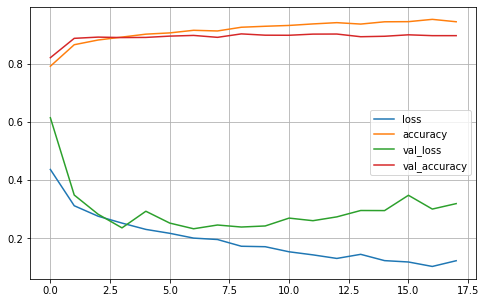

In [42]:
GenderModel.save("GenderModel.h5")
pd.DataFrame(Gender_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

**Measuring Accuracy Using Cross-Validation**

In [43]:
loss, acc = GenderModel.evaluate(X_test,y_gender_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.37847667932510376
Test Accuracy: 0.8909512758255005


In [44]:
y_gender_test[:10]

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 0])

In [45]:
y_gender_pred = GenderModel.predict(X_test)
np.transpose(np.round(y_gender_pred))

array([[1., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [46]:
def plot(X,y_age,y_gender):
    if y_gender<=0.5:
        plt.title('Gender is Male and Age is around ' +str(y_age))
        
    else:
        plt.title('Gender is Female and Age is around ' +str(y_age))
    plt.imshow(X.reshape(48,48))
    plt.show()

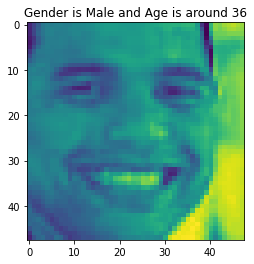

In [47]:
n=2
plot(X_test[n],int(y_age_pred[n]),y_gender_pred[n])

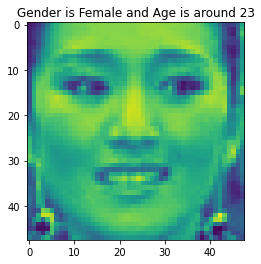

In [48]:
n=4
plot(X_test[n],int(y_age_pred[n]),y_gender_pred[n])

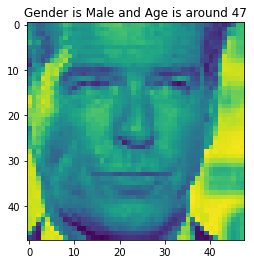

In [50]:
n=9
plot(X_test[n],int(y_age_pred[n]),y_gender_pred[n])

In [51]:
!deepCC ageModel.h5

[INFO]
Reading [keras model] 'ageModel.h5'
[SUCCESS]
Saved 'ageModel.onnx'
[INFO]
Reading [onnx model] 'ageModel.onnx'
[INFO]
Model info:
  ir_vesion : 5
  doc       : 
[WARNING]
[ONNX]: terminal (input/output) input_1's shape is less than 1. Changing it to 1.
[WARNING]
[ONNX]: terminal (input/output) dense_1's shape is less than 1. Changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_1) as io node.
[INFO]
Running DNNC graph sanity check ...
[SUCCESS]
Passed sanity check.
[INFO]
Writing C++ file 'ageModel_deepC/ageModel.cpp'
[INFO]
deepSea model files are ready in 'ageModel_deepC/' 
[RUNNING COMMAND]
g++ -std=c++11 -O3 -fno-rtti -fno-exceptions -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 ageModel_deepC/ageModel.cpp -o ageModel_deepC/ageModel.exe
[RUNNING COMMAND]
size "ageModel_deepC/a

In [52]:
!deepCC GenderModel.h5

[INFO]
Reading [keras model] 'GenderModel.h5'
[SUCCESS]
Saved 'GenderModel.onnx'
[INFO]
Reading [onnx model] 'GenderModel.onnx'
[INFO]
Model info:
  ir_vesion : 5
  doc       : 
[WARNING]
[ONNX]: terminal (input/output) input_1's shape is less than 1. Changing it to 1.
[WARNING]
[ONNX]: terminal (input/output) dense_1's shape is less than 1. Changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_1) as io node.
[INFO]
Running DNNC graph sanity check ...
[SUCCESS]
Passed sanity check.
[INFO]
Writing C++ file 'GenderModel_deepC/GenderModel.cpp'
[INFO]
deepSea model files are ready in 'GenderModel_deepC/' 
[RUNNING COMMAND]
g++ -std=c++11 -O3 -fno-rtti -fno-exceptions -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 GenderModel_deepC/GenderModel.cpp -o GenderModel_deepC/GenderModel.exe
[RUNNING C